# 4. Mushroom foraging

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [52]:
import pandas as pd
import numpy as np
from nltk import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv', delimiter = ';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


It's up to you how you approach this data, but at a minimum, your analysis should include:

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.

## Data Preparation

### Data inspection

In [53]:
# Retrieving information about datatypes and missing values
df.info()

# Checking for unique values for every column
for column in df.columns:
    print(f"{column}, {df[column].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

#### Data inspection findings
By inspecting the dataset structure, data types and missing values, we observe that it contains 61.069 entries and 21 columns. Among these columns, there are 3 numerical features and 18 categorical features. Several columns contain missing values (NaN), which must be addressed during data preparation


### Handling missing values
Columns with significant missing data:
   - stem-root(9531 non-null values)
   - veil-type(3177 non-null values)
   - veil-color (7413 non-null values)
   - spore-print-color(6354 non-null values)

Given the significant amount of missing data, these columns are unlikely to contribute meaningfully to our models performance. Therefore we decide to remove them entirely from the dataset.

Remaining columns with missing data:
   - cap-surface
   - stem-surface
   - gill-spacing
   - gill-attachment
   - ring-type

Possible strategies for handling missing values:
   - Removing all entries containing missing values, would result in substantial data loss
   - Filling missing values with a new category: "missing", for categorical columns
   - Filling missing values with the most frequent category, the mode.

Since all remaining columns with missing values are categorical, we choose the second strategy, creating a new category labeled "missing"


In [54]:
# Removing columns with the least amount of non-null
df_reduced = df.drop(['stem-root', 'veil-type', 'veil-color', 'spore-print-color'], axis=1)

# Filling NaN-values with "missing" category
categorical_columns_with_nan = ['cap-surface', 'gill-attachment', 'stem-surface', 'gill-spacing', 'ring-type']

df_reduced[categorical_columns_with_nan] = df_reduced[categorical_columns_with_nan].fillna('missing')

# Testing if there still is NaN values
df_reduced.isnull().sum().sum()

np.int64(0)

### Analysis of class distribution

In [55]:
print(df_reduced['class'].value_counts(normalize=True))

class
p    0.554913
e    0.445087
Name: proportion, dtype: float64


#### Findings for class distribution analysis
Due to the slight class imbalance (55% poisonous vs. 45% edible), accuracy alone is not sufficient to assess model quality. We therefore focus on:

- Recall: To minimize the risk of misclassifying poisonous mushrooms as edible.
- Precision: To reduce false positives and ensure reliability.
- F1-score: As our primary metric, since it balances precision and recall.

This is especially relevant in our safety-focused context.

### Numerical features

In [56]:
df_reduced[['cap-diameter', 'stem-height', 'stem-width']].describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


#### Findings behind numerical features analysis
Through our analysis, we observe extreme outliers in all numerical features. For instance, in the feature cap-diameter the majority of mushrooms have a cap-diameter between 3.4cm and 8.5cm, yet there is an unusual observation of 62.3cm, indicating either measurement errors or exceptionally rare cases. Similarly, "stem-width" contains an extreme value of 103.9 cm, which also appears to be highly improbable.

*Options for handling outliers*
- Removing outliers using percentiles, e.g. removing values above the 99th percentile.
- Retaining outliers, relying on robust models such as Random Forest to handle them, and employing scaling techniques when working with Logistic Regression.

We choose the first method - removing outliers - since these extreme values likely represents data collection errors or anomalies rather that genuine variations. Removing these outliers ensures that our models can train on reliable and representative data, thus improving overall model accuracy and performance.

In [57]:
# Removing extreme outliers with 99th percentile
for col in ['cap-diameter', 'stem-height', 'stem-width']:
    upper_limit = np.percentile(df_reduced[col], 99)
    df_reduced = df_reduced[df_reduced[col] <= upper_limit]


### One-hot encoding of categorical features
Since machine learning models require numerical input, we transform our categorical features using One-hot encoding. This technique converts each categorical variable into multiple binary columns, each representing a distinct category. A value of `1` indicates the presence of a particular category, while `0` indicates its absence. We apply the encoding using pandas' `get_dummies()` function with the parameter `drop_first=True` to avoid multi collinearity issues.

In [58]:
# Applying one-hot encoding
df_encoded = pd.get_dummies(df_reduced, drop_first = True)

### Classification models
We will use two classification models to evaluate our dataset:
- Logistic Regression (baseline): Chosen for its simplicity, interpretability, and efficiency, making it ideal as a baseline model.
- Decision Tree: Chosen due to its interpretability, robustness to feature scale, and effectiveness in handling categorical features.

To properly assess and tune our models, we split our dataset into three distinct sets:
- Training set (60%): Used for fitting the model.
- Validation set (20%): Used for hyperparameter tuning and model selection.
- Test set (20%): Used for the final unbiased evaluation of model performance.

In [59]:
from sklearn.model_selection import train_test_split

# First, splitting the data set into temporary set of 80% and a test set of 20%
X_temp, X_test, y_temp, y_test = train_test_split(df_encoded.drop('class_p', axis=1),   df_encoded['class_p'], test_size=0.2, random_state=42, stratify=df_encoded['class_p'])

# Next, split the temporary set into 60% training set and 20% validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Verify dataset sizes
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Validation set size: {X_val.shape[0]} samples')
print(f'Test set size: {X_test.shape[0]} samples')

Training set size: 35553 samples
Validation set size: 11851 samples
Test set size: 11852 samples


### Training classification models

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Scaling numerical features for Logistic Regression
scaler = StandardScaler()

# Fit scaler only on training data, then transform training, validation, and test data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Training Logistic Regression model on scaled data
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Evaluating Logistic Regression model on validation set
y_val_pred_lr = lr_model.predict(X_val_scaled)
print("Logistic Regression performance on validation set:")
print(classification_report(y_val, y_val_pred_lr))

# Training Decision Tree model (scaling not required)
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Evaluating Decision Tree model on validation set (using original, unscaled data)
y_val_pred_tree = tree_model.predict(X_val)
print("Decision Tree performance on validation set:")
print(classification_report(y_val, y_val_pred_tree))


Logistic Regression performance on validation set:
              precision    recall  f1-score   support

       False       0.78      0.81      0.80      5128
        True       0.85      0.83      0.84      6723

    accuracy                           0.82     11851
   macro avg       0.82      0.82      0.82     11851
weighted avg       0.82      0.82      0.82     11851

Decision Tree performance on validation set:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5128
        True       1.00      1.00      1.00      6723

    accuracy                           1.00     11851
   macro avg       1.00      1.00      1.00     11851
weighted avg       1.00      1.00      1.00     11851



### Results summary
- Logistic Regression achieved an F1-score of 0.84(poisonous) and 0.8(edible) which indicates a stable perfomance and minimal need for adjustment.
- Decision Tree, reached perfect scores, a clear sign of overfitting. We will proceed with hyperparameter tuning


### Hyperparameter tuning and validation methodologies
To improve model performance and avoid overfitting, we perform hyperparameter tuning — the process of systematically selecting the best configuration of model settings. Instead of manually guessing, we use **GridSearchCV**, which automates this search by testing all parameter combinations.

Two validation strategies are used:

- **Hold-out validation set (20%)**: For unbiased evaluation of tuned models.
- **5-fold cross-validation**: Used inside GridSearchCV to ensure stable and generalizable parameter selection across different data splits.

The parameter grid for each model included commonly adjusted settings, such as C for Logistic Regression and max_depth for Decision Tree. For both models, the best configuration was selected based on the highest F1-score across the 5 folds.

Tuning is guided by the **F1-score**, as it balances precision and recall — which is crucial in our safety-critical classification context. The best hyperparameter settings are then used to retrain the models for final evaluation.


In [67]:
# Hyperparameter tuning for Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
}

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_lr,
    scoring='f1',
    cv=5,
)

# Fit GridSearchCV on scaled training data
grid_search_lr.fit(X_train_scaled, y_train)

# Print best hyperparameters
print("Best Logistic Regression parameters:", grid_search_lr.best_params_)

# Evaluate the best Logistic Regression model on validation set
best_lr_model = grid_search_lr.best_estimator_
y_val_pred_lr = best_lr_model.predict(X_val_scaled)
print("Logistic Regression performance after tuning:")
print(classification_report(y_val, y_val_pred_lr))

Best Logistic Regression parameters: {'C': 0.01}
Logistic Regression performance after tuning:
              precision    recall  f1-score   support

       False       0.78      0.81      0.80      5128
        True       0.85      0.83      0.84      6723

    accuracy                           0.82     11851
   macro avg       0.82      0.82      0.82     11851
weighted avg       0.82      0.82      0.82     11851



In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define parameter grid for Decision Tree
param_grid_tree = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_tree,
    scoring='f1',
    cv=5,
)

# Fit GridSearchCV on unscaled training data
grid_search_tree.fit(X_train, y_train)

# Print best hyperparameters
print("Best Decision Tree parameters:", grid_search_tree.best_params_)

# Evaluate best Decision Tree model on validation set
best_tree_model = grid_search_tree.best_estimator_
y_val_pred_tree = best_tree_model.predict(X_val)
print("Decision Tree performance after tuning:")
print(classification_report(y_val, y_val_pred_tree))


Best Decision Tree parameters: {'max_depth': 10, 'min_samples_split': 2}
Decision Tree performance after tuning:
              precision    recall  f1-score   support

       False       0.82      0.93      0.87      5128
        True       0.94      0.84      0.89      6723

    accuracy                           0.88     11851
   macro avg       0.88      0.89      0.88     11851
weighted avg       0.89      0.88      0.88     11851



### Validation results after hyperparameter tuning

After tuning both models using GridSearchCV and 5-fold cross-validation, we compared their performance on the validation set.

- **Logistic Regression** achieved an F1-score of 0.84 for poisonous mushrooms and 0.80 for edible. Performance remained stable compared to the initial run, suggesting the default settings were already close to optimal.

- **Decision Tree**, tuned with a maximum depth of 10 and a minimum split of 2, showed improved generalization. It achieved an F1-score of 0.89 (poisonous) and 0.87 (edible), indicating stronger performance overall.

Based on these results, the Decision Tree model appears to perform better, particularly in terms of recall and overall balance. However, we now evaluate both models on the unseen test set to objectively compare final performance.

Logistic Regression performance on test set:
              precision    recall  f1-score   support

       False       0.79      0.82      0.80      5129
        True       0.86      0.83      0.84      6723

    accuracy                           0.82     11852
   macro avg       0.82      0.82      0.82     11852
weighted avg       0.83      0.82      0.83     11852



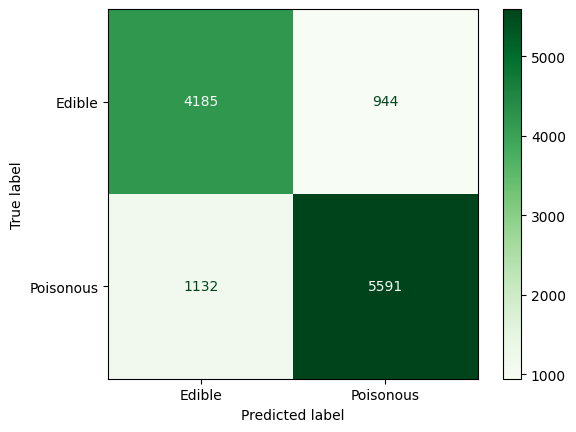

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluating Logistic Regression model based on unseen test data

# Predict on test set
y_test_pred_lr = best_lr_model.predict(X_test_scaled)

# Print classification report
print("Logistic Regression performance on test set:")
print(classification_report(y_test, y_test_pred_lr))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['Edible', 'Poisonous'])
disp_lr.plot(cmap='Greens')

Decision Tree performance on test set:
              precision    recall  f1-score   support

       False       0.81      0.93      0.87      5129
        True       0.94      0.83      0.88      6723

    accuracy                           0.88     11852
   macro avg       0.88      0.88      0.88     11852
weighted avg       0.88      0.88      0.88     11852



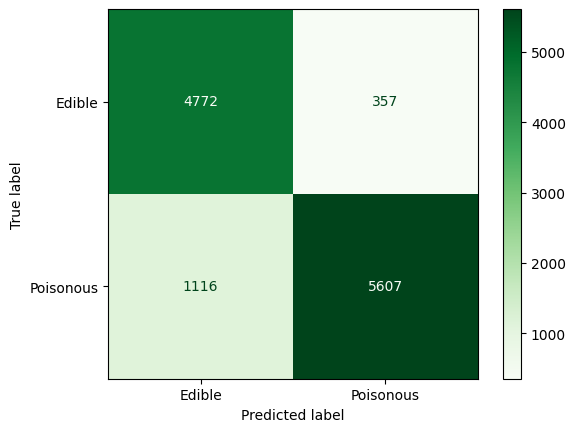

In [71]:
# Evaluating Decision Tree model based on unseen test data

# Predict on test set
y_test_pred_dt = best_tree_model.predict(X_test)

# Print classification report
print("Decision Tree performance on test set:")
print(classification_report(y_test, y_test_pred_dt))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Edible', 'Poisonous'])
disp.plot(cmap='Greens')

### Final evaluation and model selection

We evaluated both tuned models on the unseen test set. While both showed strong and balanced performance, the Decision Tree model clearly outperformed Logistic Regression:

- **Decision Tree** achieved an F1-score of 0.88 for poisonous mushrooms compared to 0.84 for Logistic Regression.
- It also had higher overall accuracy (0.88 vs. 0.82), and significantly fewer false positives and false negatives.
- The model misclassified 1116 poisonous mushrooms as edible, compared to 1132 for Logistic Regression, and had far fewer edible mushrooms falsely flagged as poisonous.

Given the critical nature of correctly identifying poisonous mushrooms, the Decision Tree’s strong balance of **high precision** and **high recall** makes it the best choice.
We therefore select the **tuned Decision Tree model** as our final classifier.


### Conclusion

In this project, classification models were developed to predict whether mushrooms are edible or poisonous. The process involved data preparation, model training, and hyperparameter tuning using GridSearchCV, with both Logistic Regression and Decision Tree algorithms being evaluated.

After tuning, the Decision Tree performed best, with higher precision and F1-score than Logistic Regression. It also made fewer classification mistakes overall.

However, the model still misclassified more than 1100 poisonous mushrooms as edible. In a real-life situation, this would be a serious problem. So even though the model performs well overall, it’s not yet reliable enough for practical use.

Further improvements could include trying more advanced models, better tuning, or adjusting how the data is handled to reduce the number of critical errors.


In [75]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


SVM performance on validation set:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5128
        True       1.00      1.00      1.00      6723

    accuracy                           1.00     11851
   macro avg       1.00      1.00      1.00     11851
weighted avg       1.00      1.00      1.00     11851



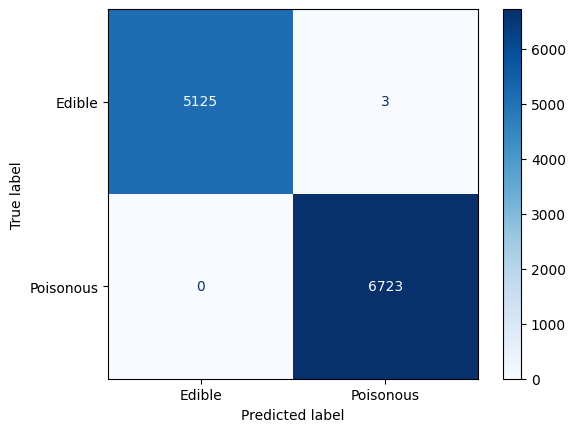

In [76]:
# SVM requires scaled data
svm_model = SVC(random_state=42)

# Fit the model on the scaled training data
svm_model.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_scaled)

# Print performance
print("SVM performance on validation set:")
print(classification_report(y_val, y_val_pred_svm))

# Optional: Confusion matrix
cm = confusion_matrix(y_val, y_val_pred_svm)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Edible', 'Poisonous']).plot(cmap='Greens')


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid_lsvc = {
    'C': [0.1, 1, 10]
}

grid_search_lsvc = GridSearchCV(
    LinearSVC(random_state=42, max_iter=10000),
    param_grid_lsvc,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_search_lsvc.fit(X_train_scaled, y_train)

# Best model and evaluation
best_lsvc = grid_search_lsvc.best_estimator_
print("Best LinearSVC parameters:", grid_search_lsvc.best_params_)

y_val_pred_lsvc = best_lsvc.predict(X_val_scaled)
print("LinearSVC performance on validation set:")
print(classification_report(y_val, y_val_pred_lsvc))
